In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Patch
import torch
import dgl
import random
import io


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D,IPythonConsole
from PIL import Image

from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load

from omtra.constants import charge_map, lig_atom_type_map

from omtra.models.ligand_encoder.vq import LigandVQVAE

from omtra.tasks.register import task_name_to_class
from omtra.eval.system import SampledSystem

/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def move_feats_to_t1(task_name: str, g: dgl.DGLHeteroGraph, t: str = '0'):
    task = task_name_to_class(task_name)
    for m in task.modalities_present:

        num_entries = g.num_nodes(m.entity_name) if m.is_node else g.num_edges(m.entity_name)
        if num_entries == 0:
            continue

        data_src = g.nodes if m.is_node else g.edges
        dk = m.data_key
        en = m.entity_name

        if t == '0' and m in task.modalities_fixed:
            data_to_copy = data_src[en].data[f'{dk}_1_true']
        else:
            data_to_copy = data_src[en].data[f'{dk}_{t}']

        data_src[en].data[f'{dk}_1'] = data_to_copy

    return g

In [ ]:
[3, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 0],
        [3, 0, 0],
        [0, 1, 0],
        [2, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 4],
        [1, 1, 4],
        [1, 1, 4],
        [0, 1, 4],
        [2, 0, 5],
        [1, 0, 6],
        [0, 0, 7],
        [2, 0, 7],
        [0, 0, 7],
        [1, 1, 4],
        [1, 1, 4],
        [0, 0, 3],
        [1, 1, 0],

In [ ]:
[[3, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 0],
        [3, 0, 0],
        [0, 1, 0],
        [2, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 4],
        [1, 1, 4],
        [1, 1, 4],
        [0, 1, 4],
        [2, 0, 5],
        [1, 0, 6],
        [0, 0, 7],
        [2, 0, 7],
        [0, 0, 7],
        [1, 1, 4],
        [1, 1, 4],
        [0, 0, 3],
        [1, 1, 0],

In [3]:
# Get pharmit dataset
cfg = quick_load.load_cfg(overrides=['task_group=no_protein'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("val")
pharmit_dataset = train_dataset.datasets['pharmit']

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [ ]:
def dgl_to_rdkit(g):
    """ Converts one DGL molecule to RDKit ligand """
    g = move_feats_to_t1('denovo_ligand', g, '1_true')
    rdkit_ligand = SampledSystem(g).get_rdkit_ligand()
    return rdkit_ligand


def get_codebook_indices(model, g):
    z_e, mask = model.encoder(g)  # Encoder output
    mask = mask.cpu().numpy().flatten().tolist()
    _, z_d, codebook_indices, _, _ = model.vq_vae(z_e)
    codebook_indices = codebook_indices.cpu().numpy().flatten().tolist()
    return codebook_indices, z_d, mask


def display_ligand_embeddings(model, pharmit_dataset, index_to_color, n_mols=1, indices=None, n_cols=3, img_size=(800,800)):
    
    if indices is None:
        indices = [random.randint(0, len(pharmit_dataset)-1) for _ in range(n_mols)]
        print(f"Using random indices: {indices}")
    else:
        n_mols = len(indices)
    
    model.eval()

    mol_images = []

    # Collect the codebook indices actually used in these molecules
    used_codebook_indices = set()

    mask_indicator = {False:'', True:'**'}

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)
        codebook_indices, _, mask = get_codebook_indices(model, g)
        used_codebook_indices.update(codebook_indices)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Create atom color map
        atom_colors = {idx: [index_to_color[val]] for idx, val in enumerate(codebook_indices)}
        highlight_radii = {idx: 0.3 for idx in atom_colors}

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        
        for idx, (a, c) in enumerate(zip(
            g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist(),
            g.nodes['lig'].data['c_1_true'].cpu().numpy().flatten().tolist())):
            options.atomLabels[idx] = f"{lig_atom_type_map[a]}, {charge_map[c]}{mask_indicator[mask[idx]]}"
            #options.atomLabels[idx] = f"{lig_atom_type_map[a]}, {charge_map[c]}"

        drawer.DrawMoleculeWithHighlights(
            ligand, '', atom_colors, {}, highlight_radii, {}
        )
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Create legend patches for used codebook indices
    legend_patches = [
        Patch(color=index_to_color[idx], label=f'Codebook {idx}')
        for idx in sorted(used_codebook_indices)
    ]
    print("number of codebook vectors used:", len(used_codebook_indices))
    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
    plt.tight_layout()
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import colorsys

def lighten_color(color, amount=1.3):
    """
    Lightens the given RGBA color by multiplying the lightness (L in HLS) by amount.
    """
    r, g, b, a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1, l * amount)  # increase lightness but max 1
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, a)

number of codebook vectors used: 38


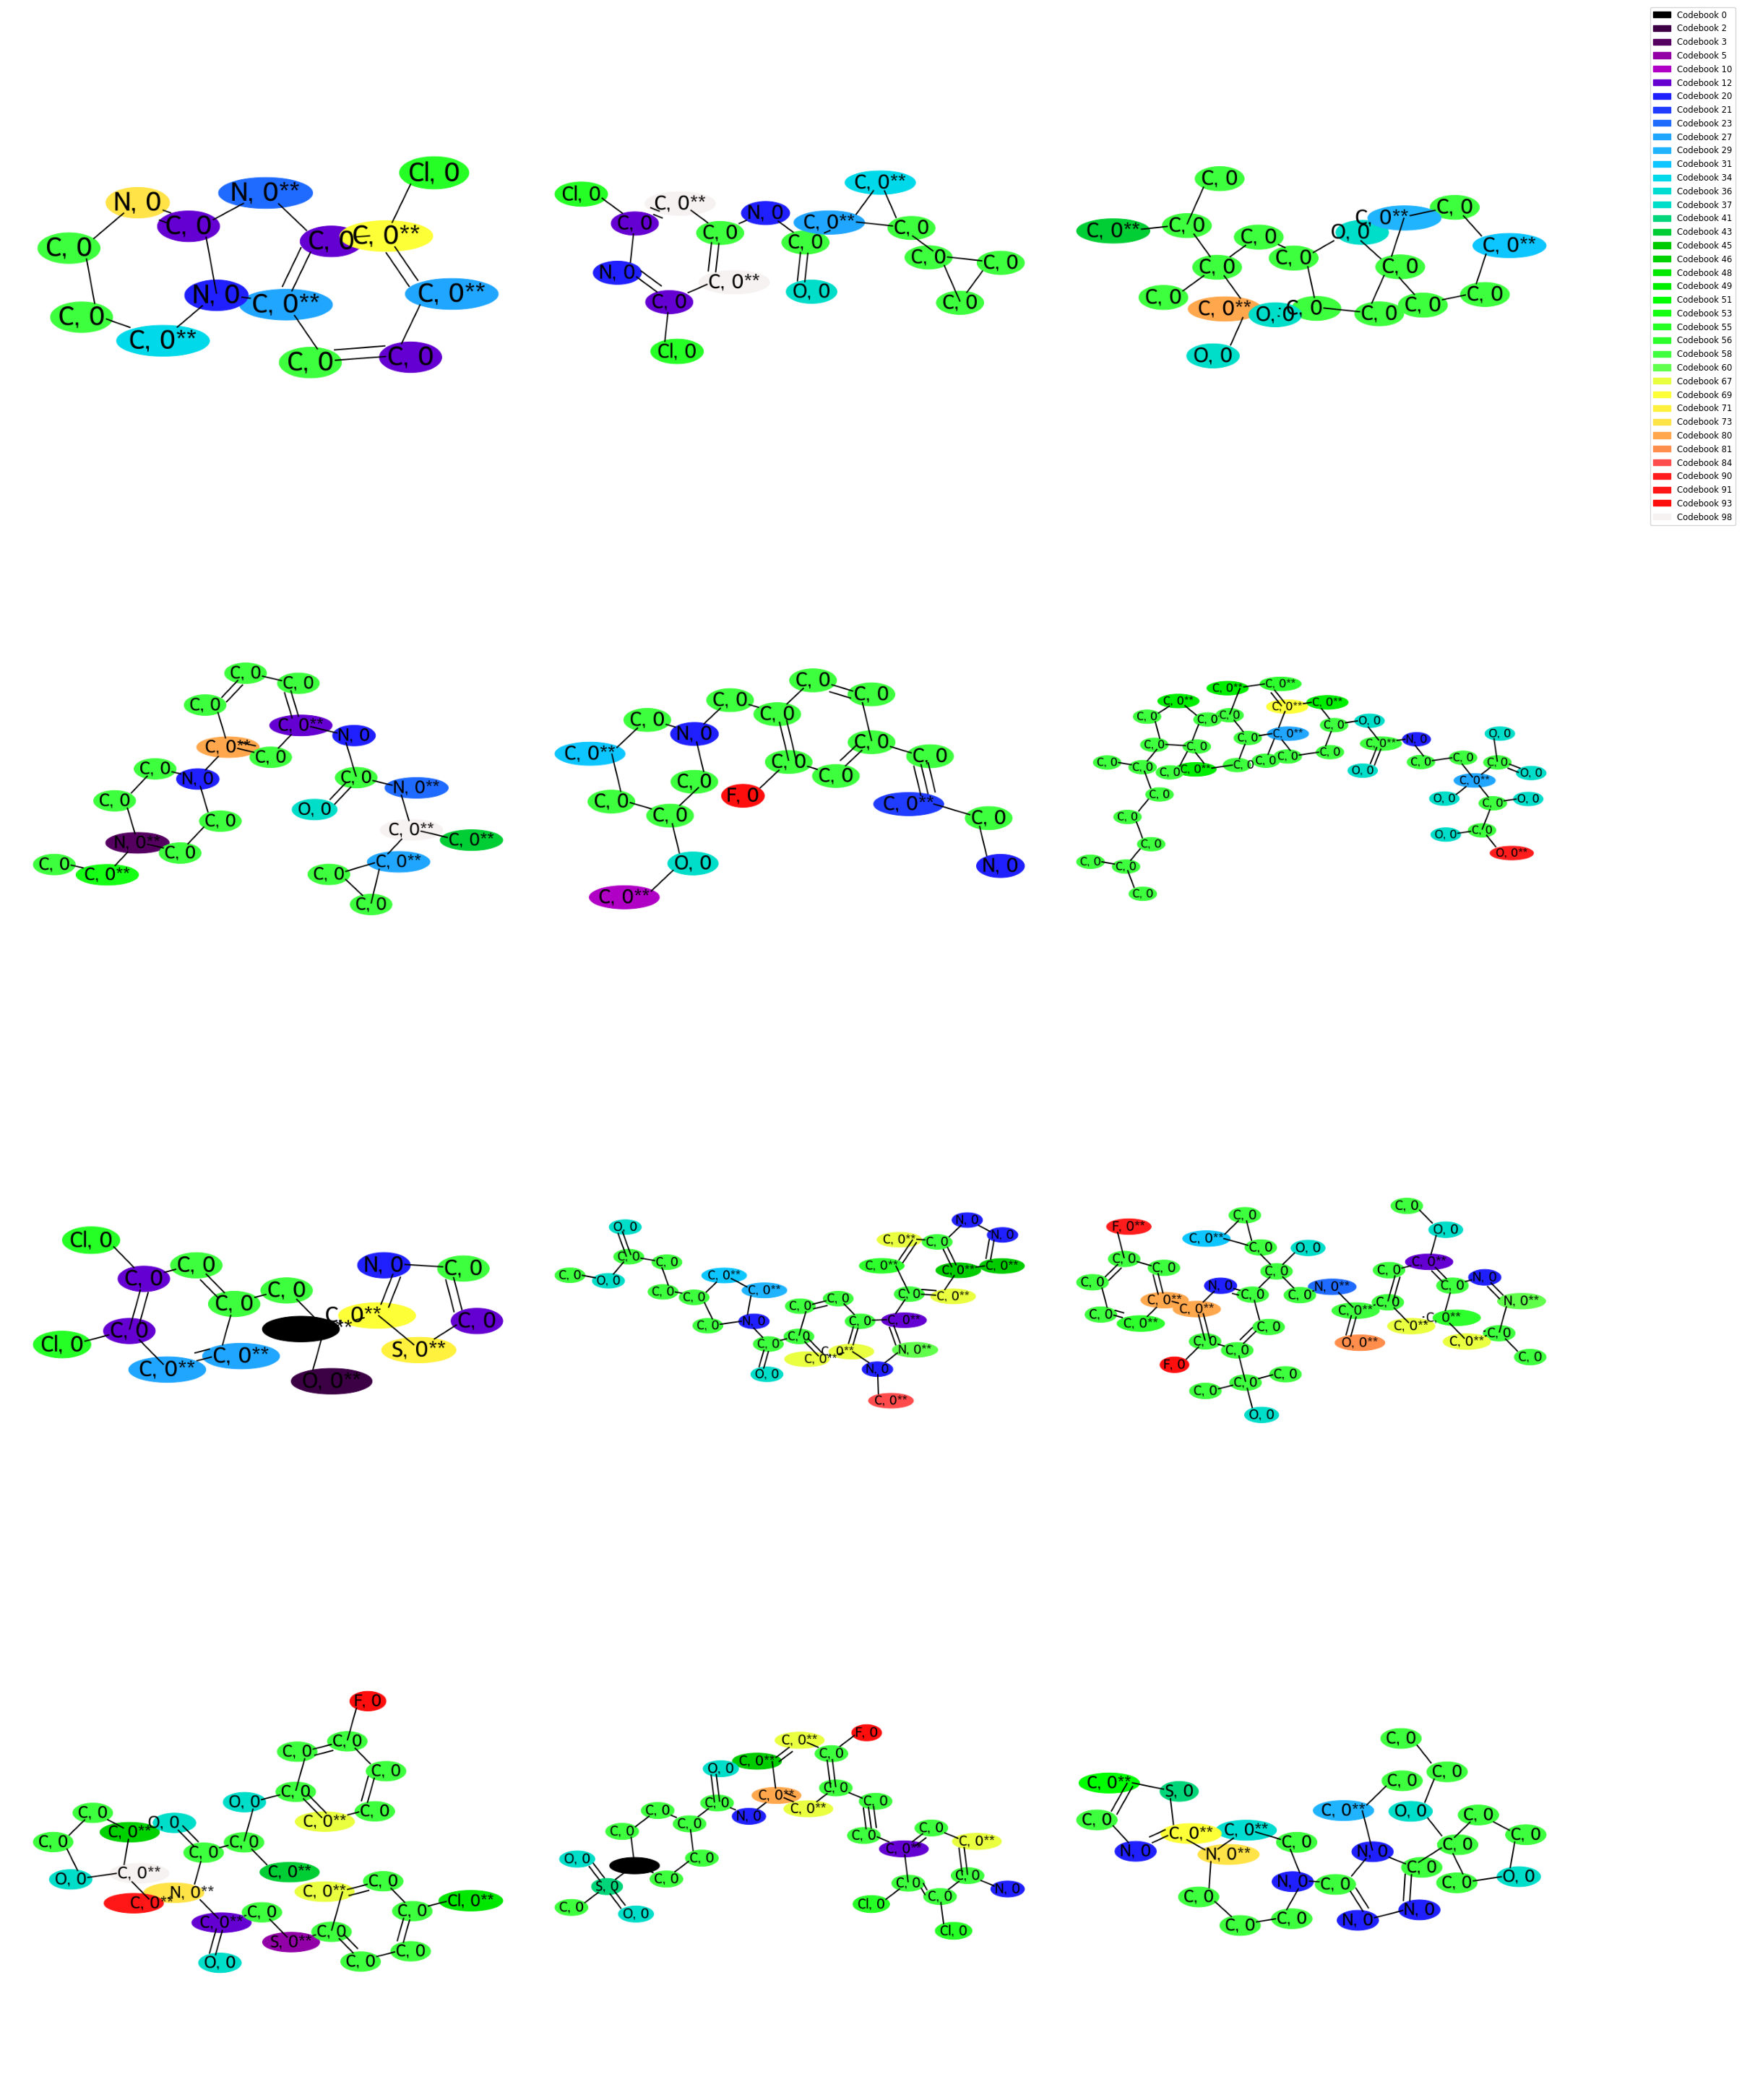

In [ ]:
# mask_prob = 0.25

checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-05-30/i_forgot_to_name_my_run_2025-05-30_16-26-592903/checkpoints/last.ckpt"
model = LigandVQVAE.load_from_checkpoint(checkpoint)

num_embeddings = model.vq_vae.num_embeddings
colormap = matplotlib.colormaps.get_cmap('nipy_spectral')

# Generate lightened colormap
index_to_color = {
    i: lighten_color(colormap(i / (num_embeddings - 1))[:4], amount=1.3)
    for i in range(num_embeddings)
}


display_ligand_embeddings(model, pharmit_dataset, index_to_color, indices=[1931434, 85523, 3009412, 24901, 3024406, 3053672, 2844411, 4950458, 2524035, 1281569, 4967550, 943354])

number of codebook vectors used: 43


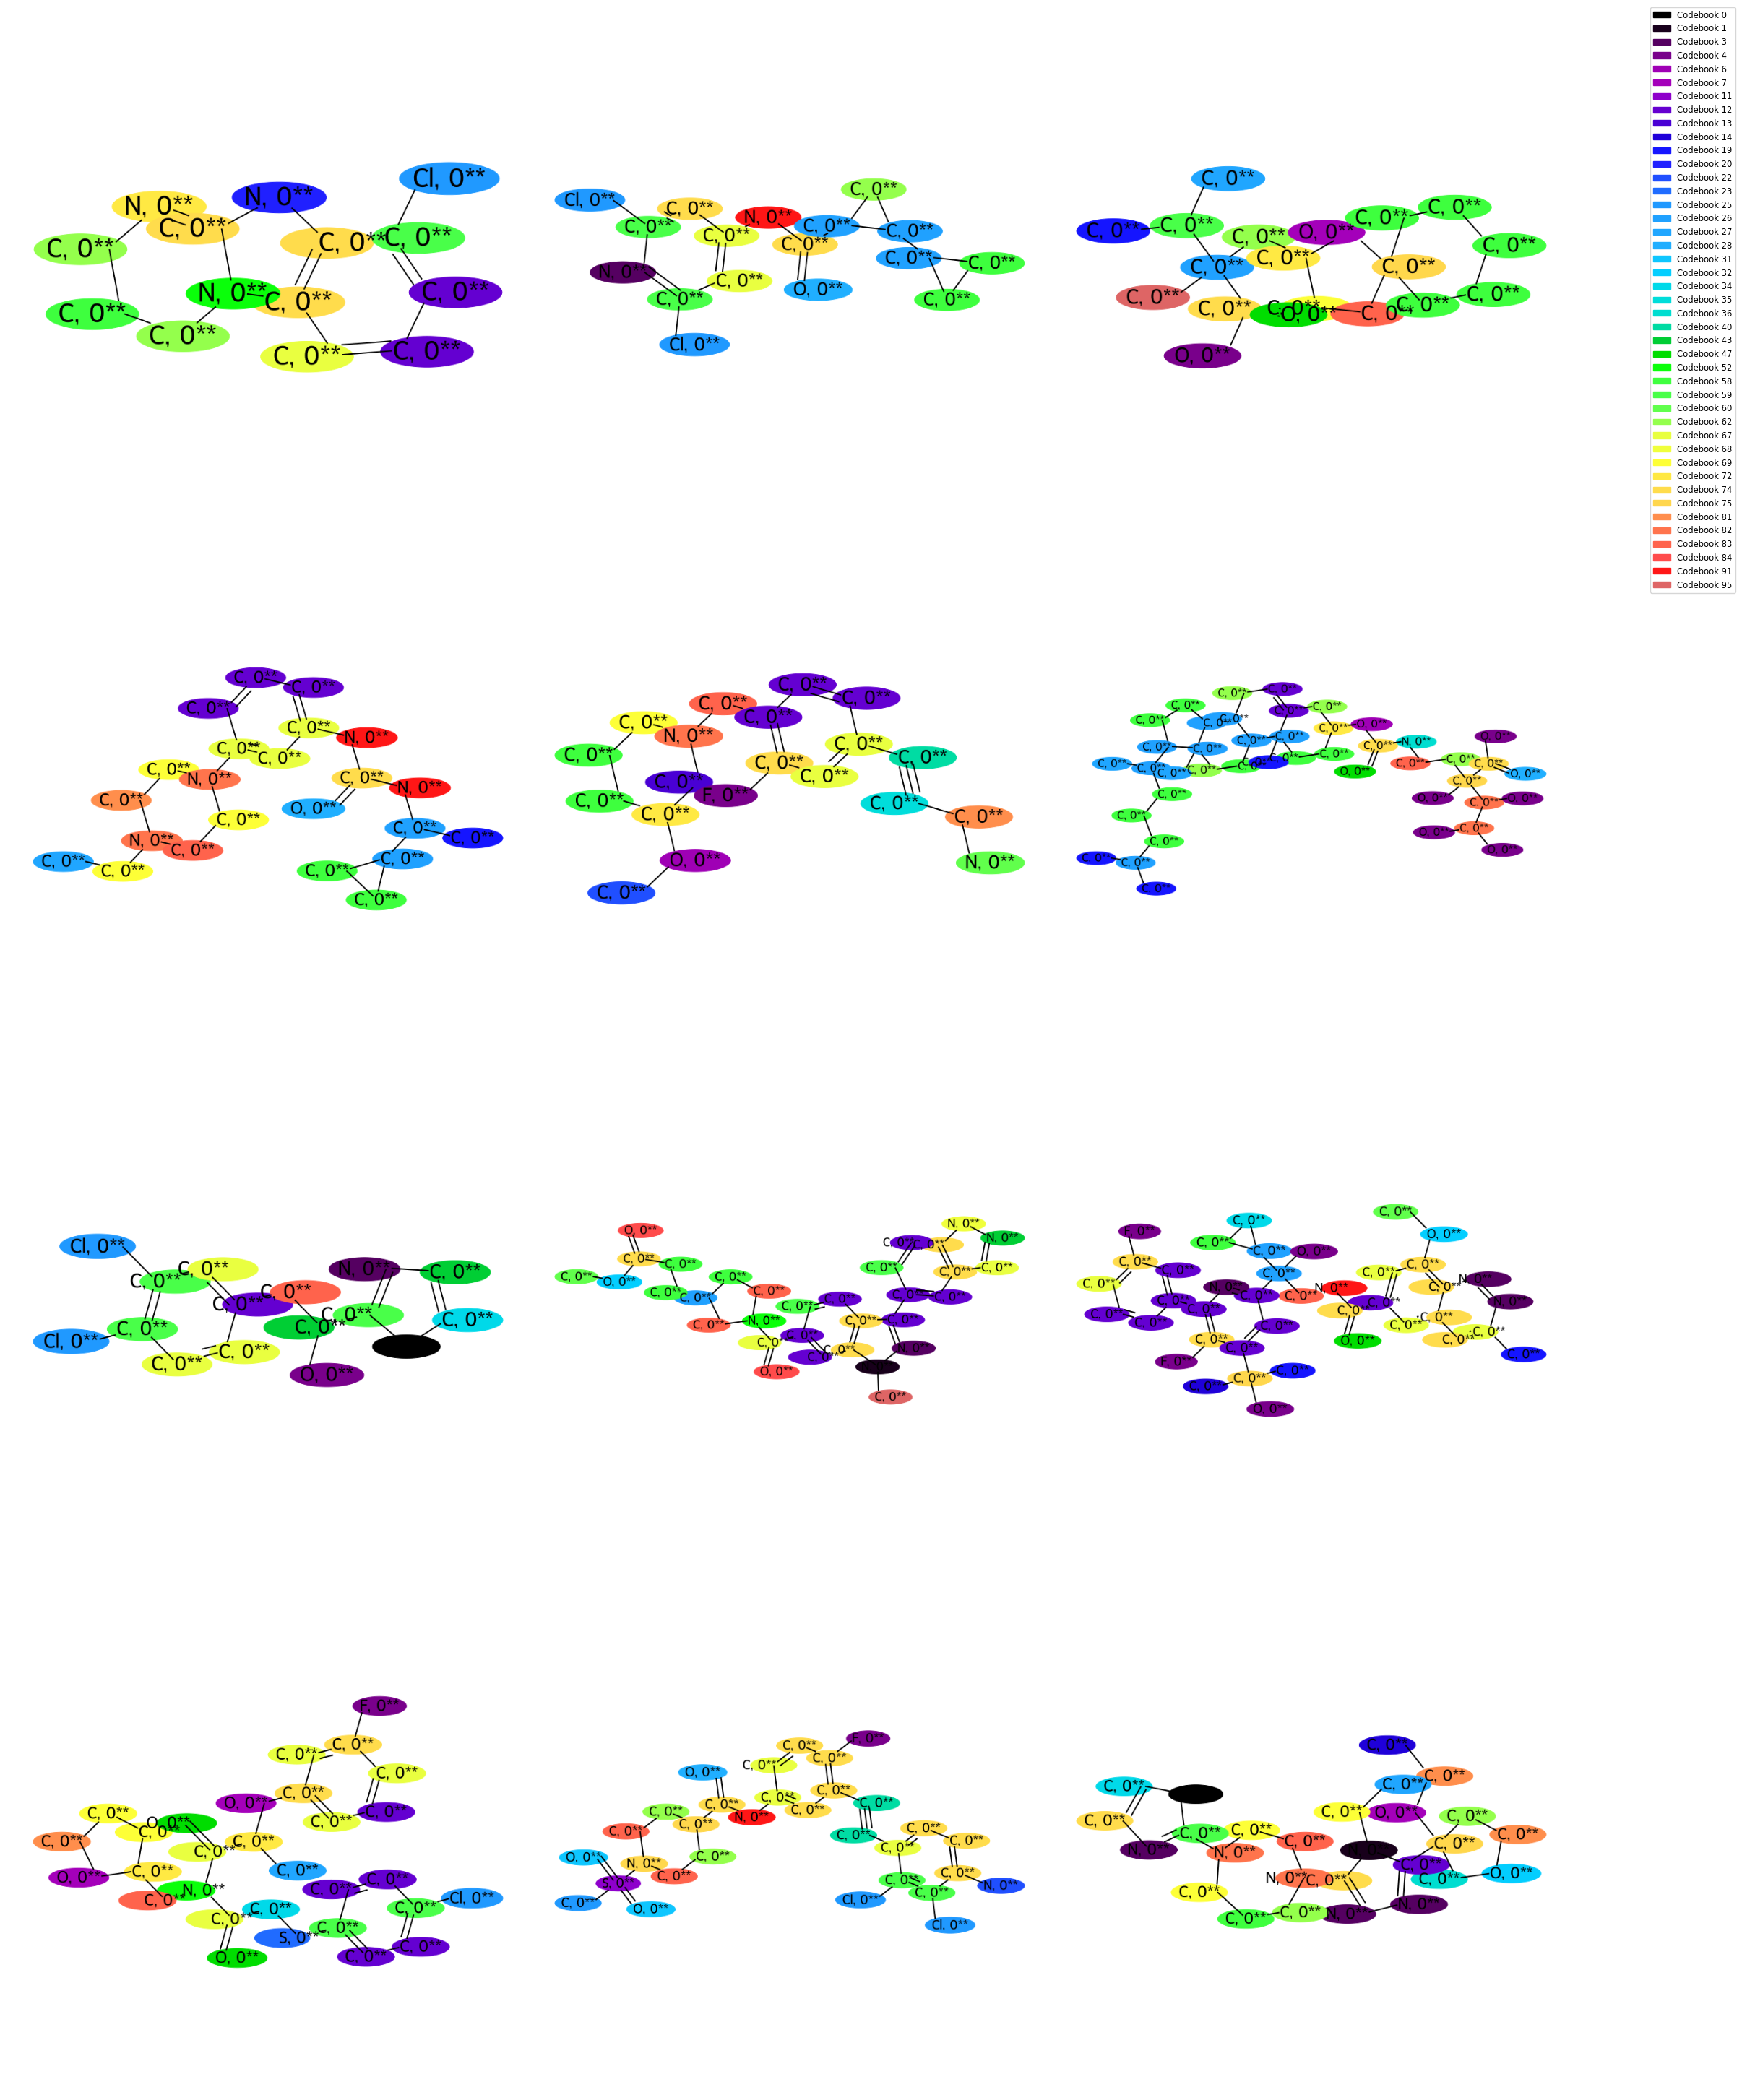

In [ ]:
# mask_prob = 0.99
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-05-30/i_forgot_to_name_my_run_2025-05-30_15-45-971985/checkpoints/last.ckpt"
model = LigandVQVAE.load_from_checkpoint(checkpoint)

display_ligand_embeddings(model, pharmit_dataset, index_to_color, indices=[1931434, 85523, 3009412, 24901, 3024406, 3053672, 2844411, 4950458, 2524035, 1281569, 4967550, 943354])

In [29]:
def display_ligands(pharmit_dataset, indices, n_cols=3, img_size=(800,800)):

    mol_images = []
    n_mols = len(indices)

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        

        for idx, a in enumerate(g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist()):
            options.atomLabels[idx] = f"{lig_atom_type_map[a]}, {idx}"


        drawer.DrawMolecule(ligand)
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [32]:
pharmit_dataset[('denovo_ligand', 5864876)]

ValueError: not enough values to unpack (expected 2, got 0)

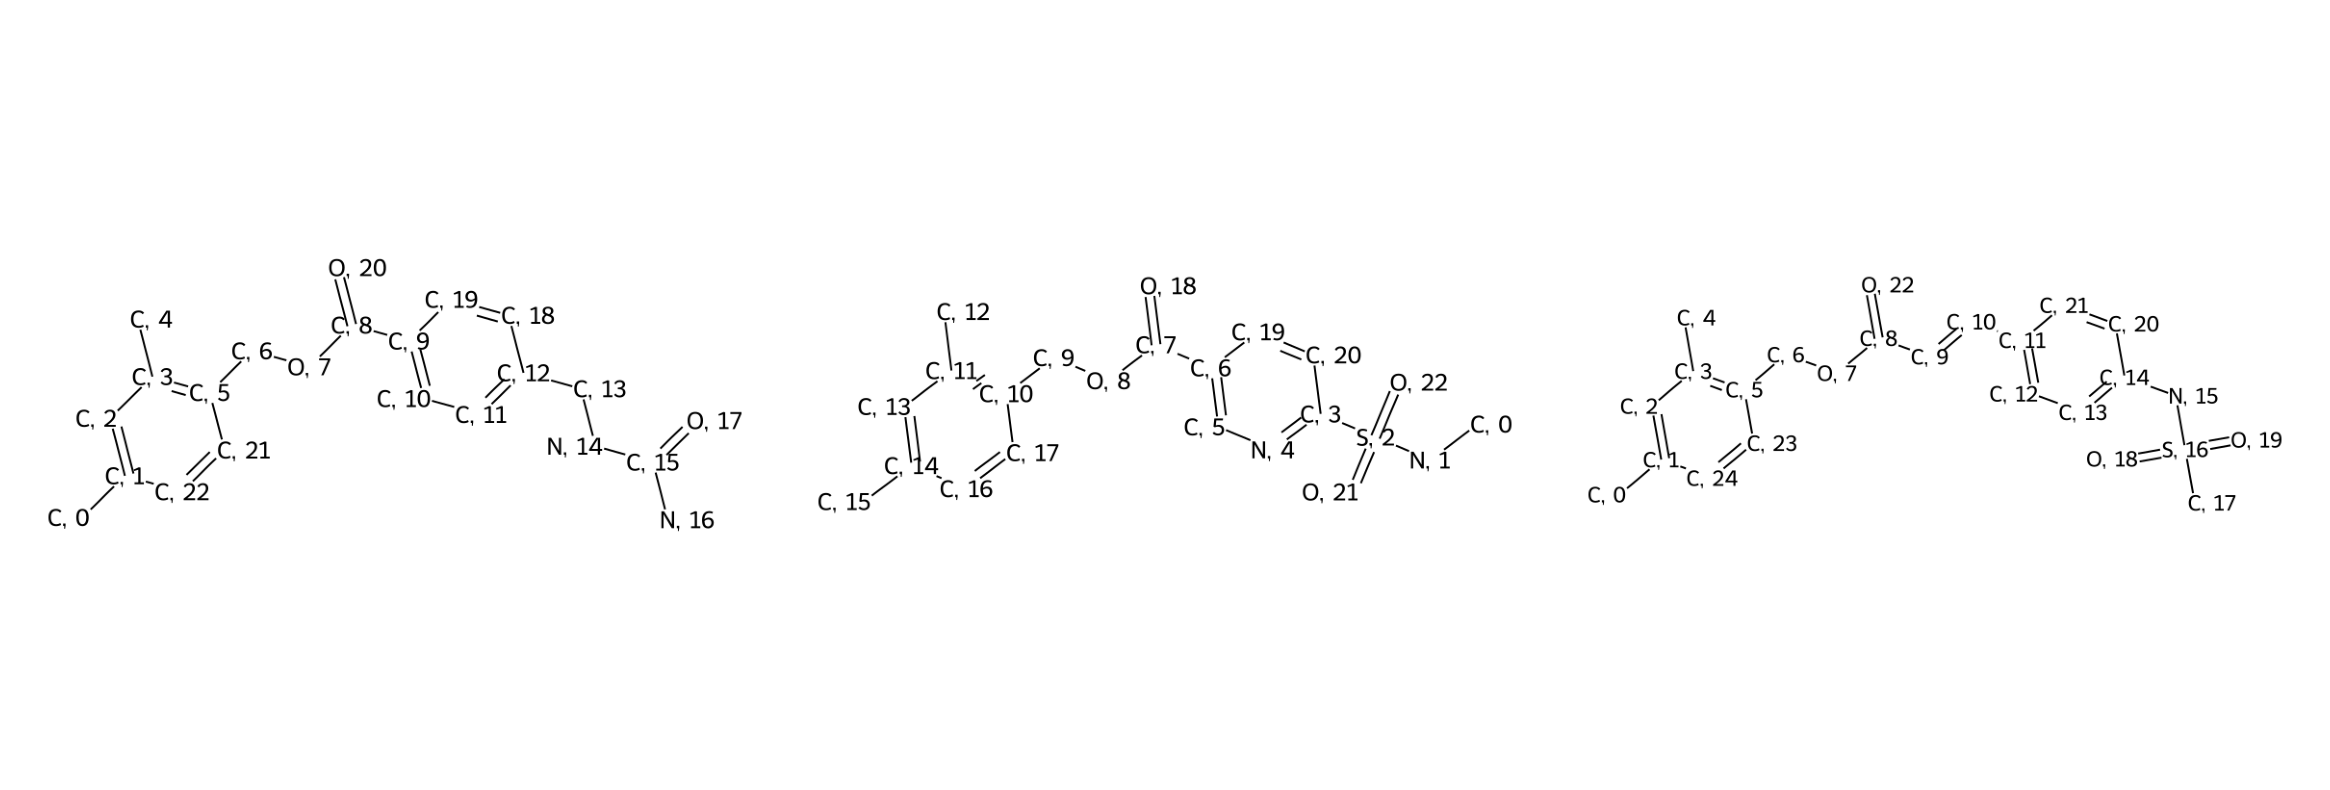

In [ ]:
display_ligands(pharmit_dataset, indices=[0,1,2])

In [ ]:
[[3, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 0],
        [3, 0, 0],
        [0, 1, 0],
        [2, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 1, 4],
        [1, 1, 4],
        [1, 1, 4],
        [0, 1, 4],
        [2, 0, 5],
        [1, 0, 6],
        [0, 0, 7],
        [2, 0, 7],
        [0, 0, 7],
        [1, 1, 4],
        [1, 1, 4],
        [0, 0, 3],
        [1, 1, 0],
        [1, 1, 0]]

In [2]:
(41+10-1)//10

5